MALA acceptance rate: 0.3663 (348/950)


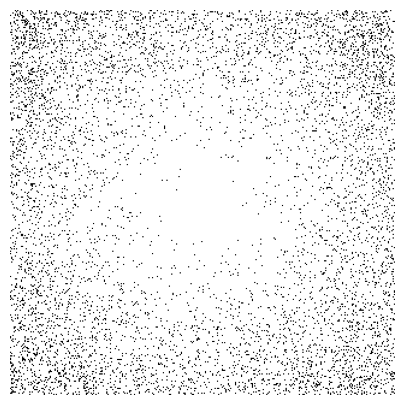

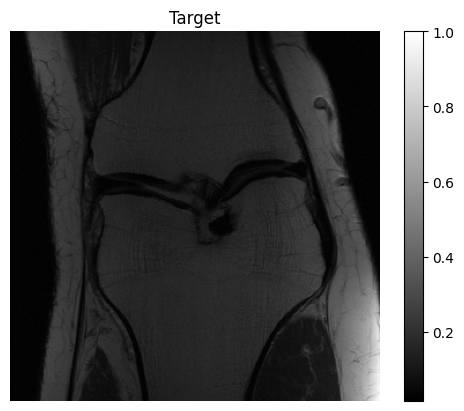

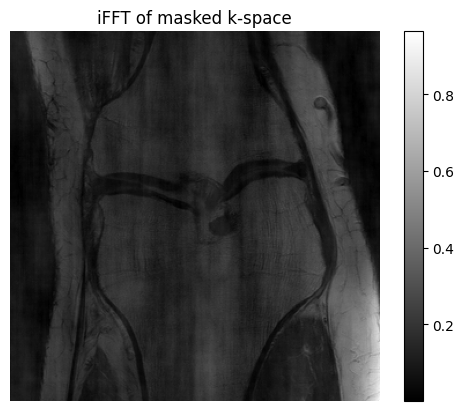

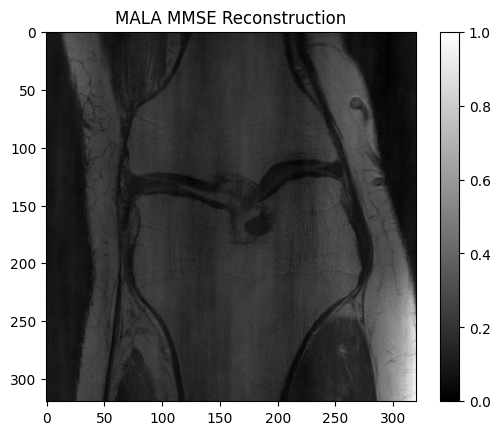

PSNR iFFT: 28.92 dB, NMSE iFFT: 0.0345, SSIM iFFT : 0.8812
None
PSNR MALA: 27.98 dB, NMSE MALA: 0.0429, SSIM MALA: 0.8908


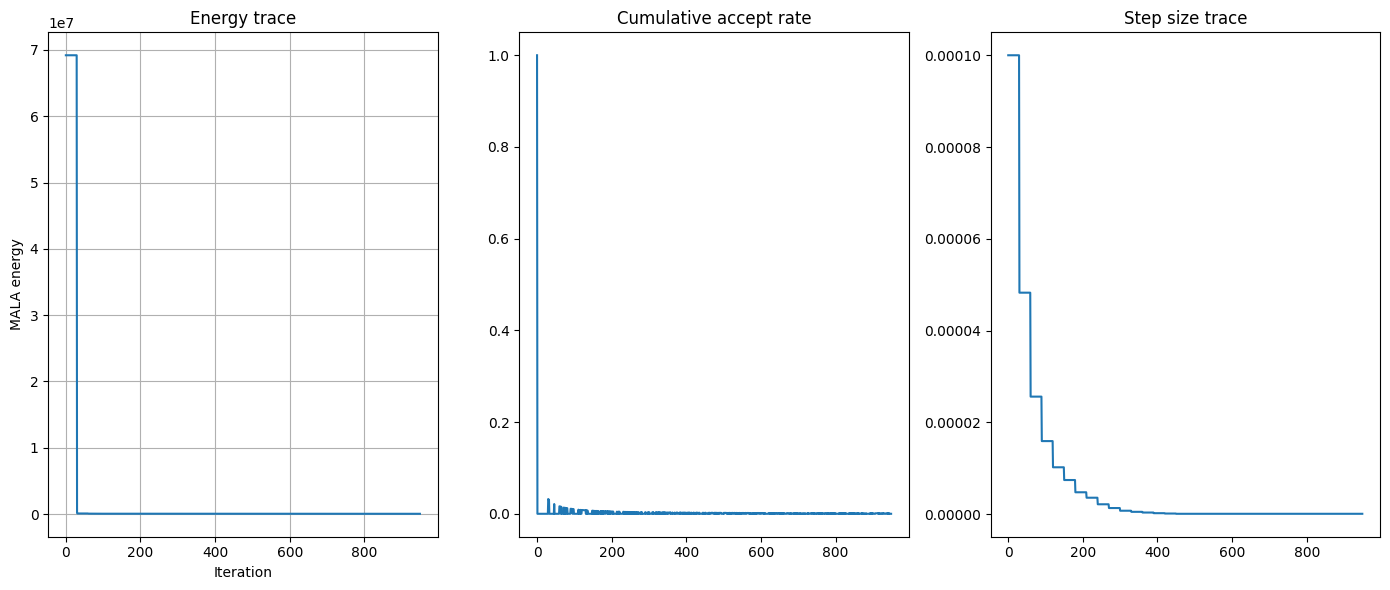

In [22]:
# MALA diagnostics

import os
import sys
import fastmri
import fastmri.data
import fastmri.data.transforms
import h5py
import torch

# Set the path to the root of your project
project_root = os.path.abspath(os.path.join(os.getcwd(), r"C:\Users\kostanjsek\bachelor_project"))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
from utilities.masks import (
    CenteredBernoulliMask,
    UniformColumnMask,
    VariableDensityMask,
    PseudoRandomColumnMask,
    RadialMask
)
from fastmri.data import transforms as T
from utilities.metrics import psnr, nmse, mean_squared_error, ssim
from MAP.map_tv_minimize import MAPEstimator
from fastmri.data.mri_data import SliceDataset
from data.load_knee_mri import load_fastmri_data
from MMSE.mmse_ula import MMSEEstimatorULA
from MMSE.mmse_mala import MMSEEstimatorMALA
import skimage as ski


train_dataset, val_dataset, test_dataset = load_fastmri_data(
    r"C:\Users\kostanjsek\Documents\knee_mri"
)

file_name = r"C:\Users\kostanjsek\Documents\knee_mri\knee_singlecoil_train\singlecoil_train/file1000662.h5"
hf = h5py.File(file_name)

volume_kspace = hf['kspace'][()]
target = hf['reconstruction_rss'][()]

slice_kspace = volume_kspace[20]
slice_target = target[20]  # match slice index to kspace slice
tensor_kspace = T.to_tensor(slice_kspace)

# slice_target = slice_target.astype(np.complex64)
slice_target = slice_target / np.max(np.abs(slice_target)) #.max()

mask = VariableDensityMask('gaussian', 1.5, seed=30).generate(slice_target.shape)
#mask = PseudoRandomColumnMask(slice_target.shape, 2, 1, seed=30).get_mask()
#mask = CenteredBernoulliMask(0.75, 0.25, seed=30).generate(slice_target.shape)

# # sigma = 0.05 
# noise = (np.random.randn(*slice_target.shape) + 1j * np.random.randn(*slice_target.shape)) * (sigma / np.sqrt(2))
y = mask * np.fft.fft2(slice_target, norm='ortho') # mask * slice_kspace


#map_estimator = MAPEstimator(mask, 0.1, 0.01, 1e-2, 0.01, 300) # def-> 0.95, 0.01, 1e-2, 0.1, 100)
# ula_estimator = MMSEEstimatorULA(mask, 0.001, 0.1, 5e-2, 1e-8, 450, 2, 250) # stepsize = 1e-2
mala_estimator = MMSEEstimatorMALA(mask, 0.005, 20*0.1, 1e-2, 1e-4, 450, 2, 250) # (mask, 0.0005, 2000*0.1, 1e-2, 1e-8, 450, 2, 250) 

samples_kept, energies, step_trace, accept_trace = mala_estimator.mala_sampling(y)
mmse = mala_estimator.compute_mmse_estimate(samples_kept)
# print(mala_estimator.mala_sampling)
# print("CALL TYPE:", mala_estimator.mala_sampling)
# print("CALLABLE?", callable(mala_estimator.mala_sampling))

# mala_estimator.test_adjoint_A(320, 320)
# mala_estimator.test_grad_div_adjoint(320, 320)
# mala_estimator.test_full_gradient(320, 320, y)

# print(f"image tv:{mala_estimator.huber_tv_2d(slice_target)}")

# visualize the mask
plt.figure(figsize=(5, 5))
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

# target
plt.imshow(slice_target / slice_target.max(), cmap="gray")
plt.title("Target")
plt.colorbar()
plt.axis("off")
plt.show()

# ifft of y for comparison
plt.imshow(np.abs(np.fft.ifft2(y, norm='ortho')), cmap="gray")
plt.title("iFFT of masked k-space")
plt.colorbar()
plt.axis("off")
plt.show()

# mala mmse
plt.imshow(np.abs(mmse), cmap="gray")
plt.title("MALA MMSE Reconstruction")
plt.colorbar()
plt.show()

psnr_ifft = psnr(np.abs(np.fft.ifft2(y, norm='ortho')), slice_target)
nmse_ifft = nmse(np.abs(np.fft.ifft2(y, norm='ortho')), slice_target)
ssim_ifft = ssim(np.abs(np.fft.ifft2(y, norm='ortho')), slice_target)
print(print(f"PSNR iFFT: {psnr_ifft:.2f} dB, NMSE iFFT: {nmse_ifft:.4f}, SSIM iFFT : {ssim_ifft:.4f}"))

psnr_mala = psnr(mmse, slice_target)
nmse_mala = nmse(mmse, slice_target)
ssim_mala = ssim(mmse, slice_target)
print(f"PSNR MALA: {psnr_mala:.2f} dB, NMSE MALA: {nmse_mala:.4f}, SSIM MALA: {ssim_mala:.4f}")

plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.plot(energies)
plt.title('Energy trace')
plt.xlabel("Iteration")
plt.ylabel("MALA energy")
plt.grid(True)
plt.subplot(1,3,2)
plt.plot(accept_trace / (np.arange(len(accept_trace))+1))
plt.title('Cumulative accept rate')
plt.subplot(1,3,3)
plt.plot(step_trace)
plt.title('Step size trace')
plt.tight_layout()
plt.show()


In [14]:
import os
import sys
import fastmri
import fastmri.data
import fastmri.data.transforms
import h5py
import torch

# Set the path to the root of your project
project_root = os.path.abspath(os.path.join(os.getcwd(), r"C:\Users\kostanjsek\bachelor_project"))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
from utilities.masks import (
    CenteredBernoulliMask,
    UniformColumnMask,
    VariableDensityMask,
    PseudoRandomColumnMask,
    RadialMask
)
from fastmri.data import transforms as T
from utilities.metrics import psnr, nmse, mean_squared_error, ssim
from MAP.map_tv_minimize import MAPEstimator
from fastmri.data.mri_data import SliceDataset
from data.load_knee_mri import load_fastmri_data
from MMSE.mmse_ula import MMSEEstimatorULA
from MMSE.mmse_mala import MMSEEstimatorMALA
import skimage as ski


train_dataset, val_dataset, test_dataset = load_fastmri_data(
    r"C:\Users\kostanjsek\Documents\knee_mri"
)

file_name = r"C:\Users\kostanjsek\Documents\knee_mri\knee_singlecoil_train\singlecoil_train/file1000662.h5"
hf = h5py.File(file_name)

volume_kspace = hf['kspace'][()]
target = hf['reconstruction_rss'][()]

slice_kspace = volume_kspace[20]
slice_target = target[20]  # match slice index to kspace slice
tensor_kspace = T.to_tensor(slice_kspace)

slice_target = slice_target / np.abs(slice_target).max()

mask = VariableDensityMask('gaussian', 1.5, seed=30).generate(slice_target.shape)
#mask = PseudoRandomColumnMask(slice_target.shape, 2, 1, seed=30).get_mask()
#mask = CenteredBernoulliMask(0.75, 0.25, seed=30).generate(slice_target.shape)

y = mask * np.fft.fft2(slice_target) # mask * slice_kspace
y = y / np.abs(y).max()
mala_estimator = MMSEEstimatorMALA(mask, 0.001, 0.1, 5e-2, 1e-8, 450, 2, 250)

def short_mala_run(est, y, step_list=[1e-6, 5e-7, 1e-7], niter=2000, burn=500):
    results = {}
    for s in step_list:
        est.mala_step_size = s
        est.burn_in = burn
        est.num_samples = 50
        est.thin = 1
        samples, energies, step_trace, accept_trace = est.mala_sampling(y)
        results[s] = samples
        print(f"accept_trace={accept_trace[-1]:.3f}")
    return results

short_mala_run(mala_estimator, y)

accept_rate: 0.0
accept_trace=0.000
accept_rate: 0.0
accept_trace=0.000
accept_rate: 0.0
accept_trace=0.000


{1e-06: [array([[0.00228697, 0.00222594, 0.00217847, ..., 0.00204639, 0.00170882,
          0.00177202],
         [0.00216645, 0.00206761, 0.00199083, ..., 0.00199036, 0.0020296 ,
          0.00225749],
         [0.00215144, 0.00228303, 0.00222578, ..., 0.00213171, 0.00225245,
          0.00223698],
         ...,
         [0.00178254, 0.00203455, 0.00208816, ..., 0.01728776, 0.01810865,
          0.01879531],
         [0.00191753, 0.00190624, 0.00200372, ..., 0.01757012, 0.01826725,
          0.01836891],
         [0.00168373, 0.0019567 , 0.00209148, ..., 0.0180724 , 0.0175082 ,
          0.01935932]], shape=(320, 320)),
  array([[0.00228697, 0.00222594, 0.00217847, ..., 0.00204639, 0.00170882,
          0.00177202],
         [0.00216645, 0.00206761, 0.00199083, ..., 0.00199036, 0.0020296 ,
          0.00225749],
         [0.00215144, 0.00228303, 0.00222578, ..., 0.00213171, 0.00225245,
          0.00223698],
         ...,
         [0.00178254, 0.00203455, 0.00208816, ..., 0.01728776, 